#### The purpose of this notebooks is to test whether the single trial beta maps produce a similar maps as the SPM univariate analysis

Method:
* 1) convert .nii to .npy : scripts/step10_nilearn/glm/cue-high_GT_cue-low/glm_numpify_ttest.py
* 2) average .npy per subject (session and run concatenated): scripts/step10_nilearn/glm/cue-high_GT_cue-low/numpy_ttest_cue.py
* 3) plot the end product here.

In [55]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img, new_img_like
from nilearn import image, plotting
import argparse
import matplotlib.pyplot as plt
from surfplot import Plot
from matplotlib import cm
import neuromaps
import nibabel as nib
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps


In [34]:
def plot_surf(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh, size=(200, 600), zoom=1.6, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

In [49]:
def plot_surf_box(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh) #, size=(600, 600)) #, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

# task-pain

In [5]:
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-high.npy"))

In [6]:
suballLv.shape

(109, 458294)

In [7]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

In [8]:
x,y,z=ref_img.shape
H = []
L = []
for index in range(suballLv.shape[0]):
    # apply masker onto numpy array (shape of #subjects x voxels)
        
    H.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    L.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )
    


In [130]:
# x,y,z=ref_img.shape
# fmri_masked_stimhigh = nifti_masker.fit_transform(
#     new_img_like(ref_img, suballHv.reshape(x,y,z, suballHv.shape[0], ))
    
#     )
# fmri_masked_stimlow = nifti_masker.fit_transform(new_img_like(ref_img, suballLv.reshape(x,y,z, suballHv.shape[0])))

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 1.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


In [10]:
fmri_masked_stimhigh = np.vstack(H)
fmri_masked_stimlow = np.vstack(L)
print(fmri_masked_stimlow.shape)

(109, 98053)


In [11]:
(fmri_masked_stimhigh - fmri_masked_stimlow).shape

(109, 98053)

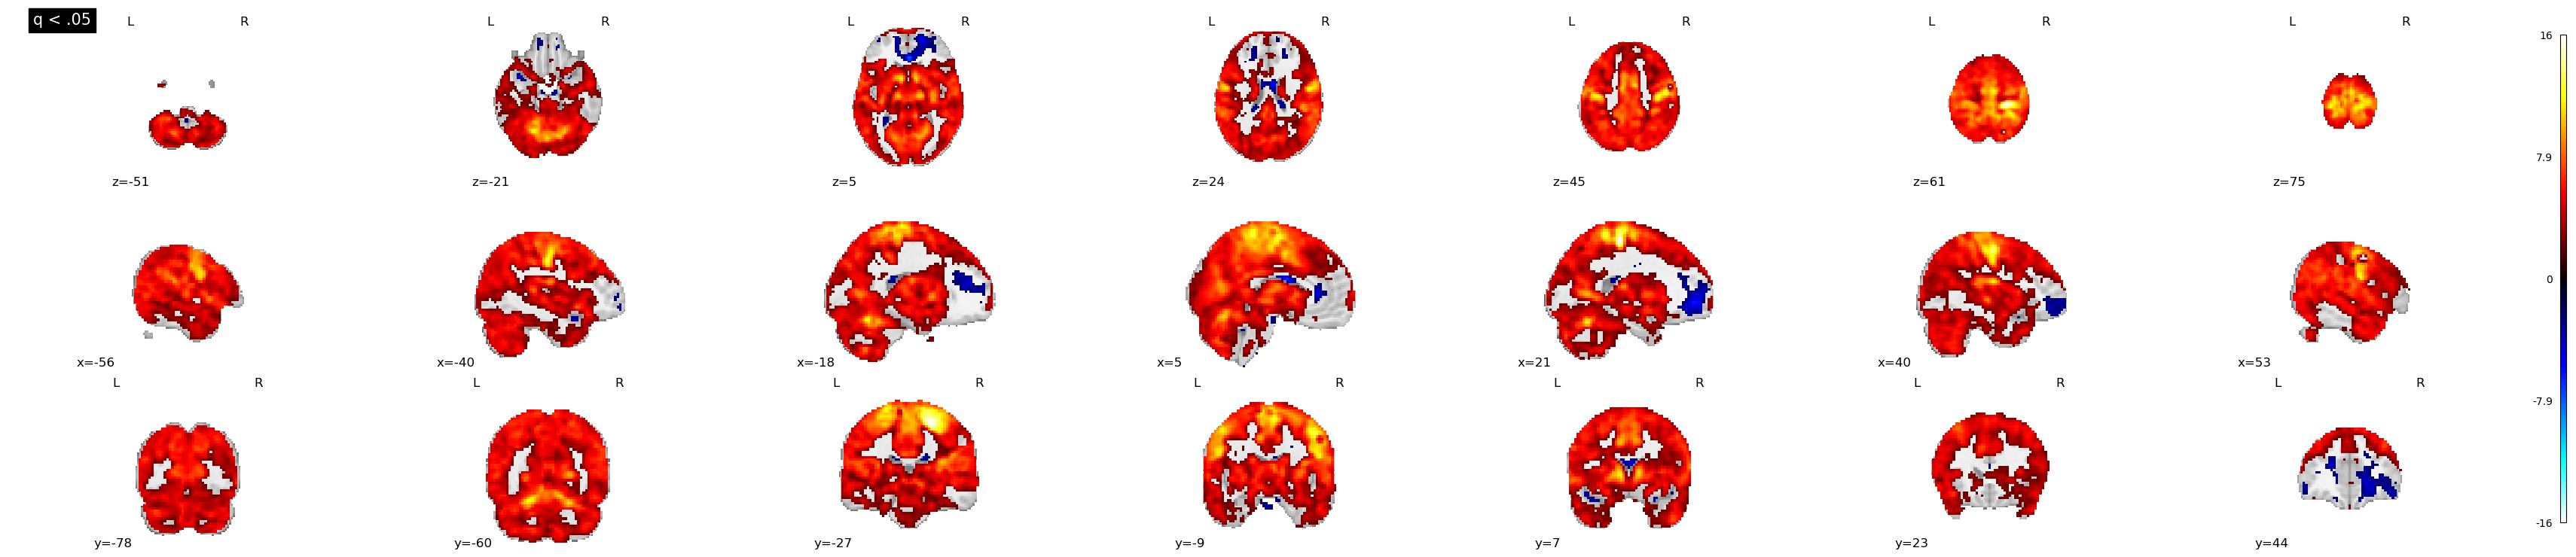

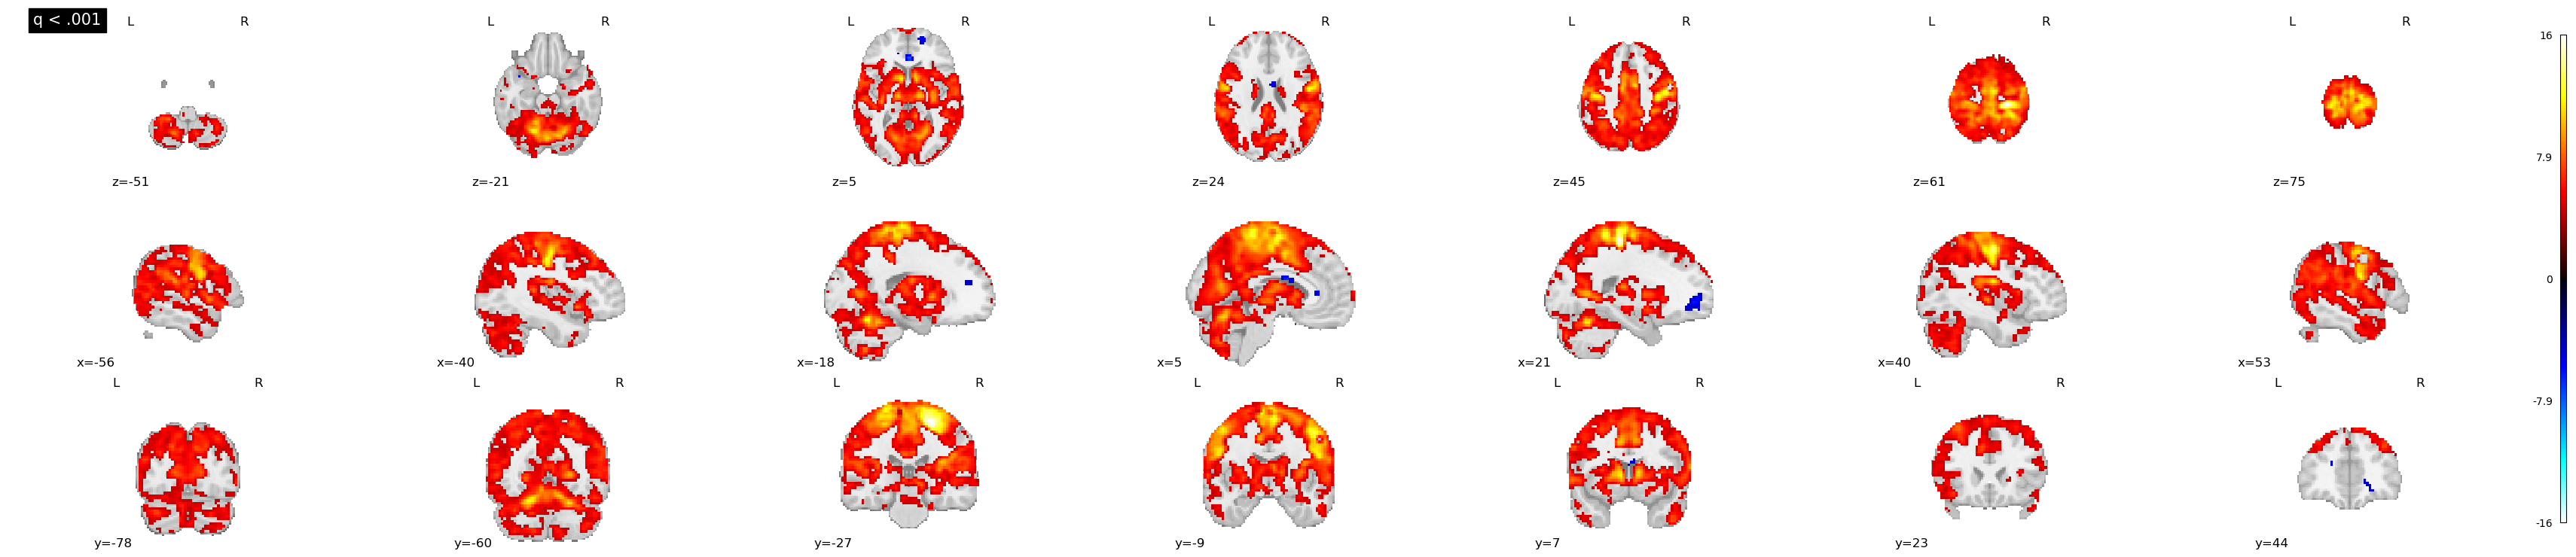

In [13]:
tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhigh, fmri_masked_stimlow, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
unthres_tmap = nifti_masker.inverse_transform(tvalues)

result_map = np.zeros(fmri_masked_stimhigh.shape[1])
result_map[qvalues < .05] = tvalues[qvalues < .05]
con_tmap = nifti_masker.inverse_transform(result_map)

result_map_001 = np.zeros(fmri_masked_stimhigh.shape[1])
result_map_001[qvalues < .0001] = tvalues[qvalues < .0001]
con_tmap_001 = nifti_masker.inverse_transform(result_map_001)

plotting.plot_stat_map(con_tmap,  display_mode = 'mosaic', title = 'q < .05')
plotting.plot_stat_map(con_tmap_001,  display_mode = 'mosaic', title = 'q < .001')
# plotting.plot_stat_map(con_bmap, threshold = 1, display_mode = 'mosaic')
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename('singletrial-tmap_task-pain_p-unthres.nii.gz')
con_tmap.to_filename('singletrial-tmap_task-pain_q-05.nii.gz')
con_tmap_001.to_filename('singletrial-tmap_task-pain_q-001.nii.gz')

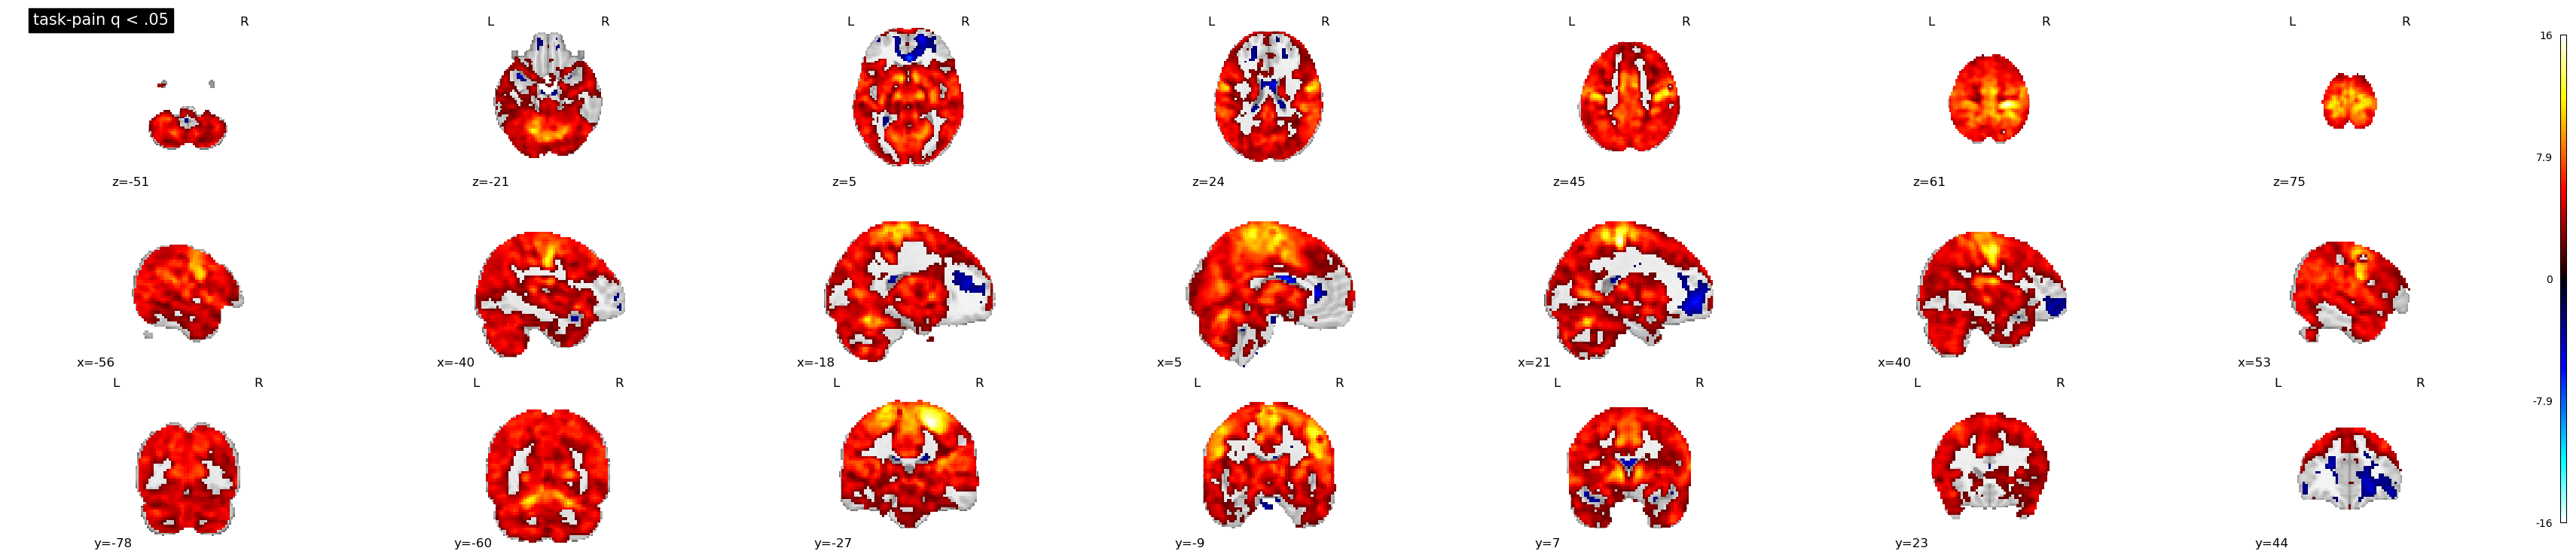

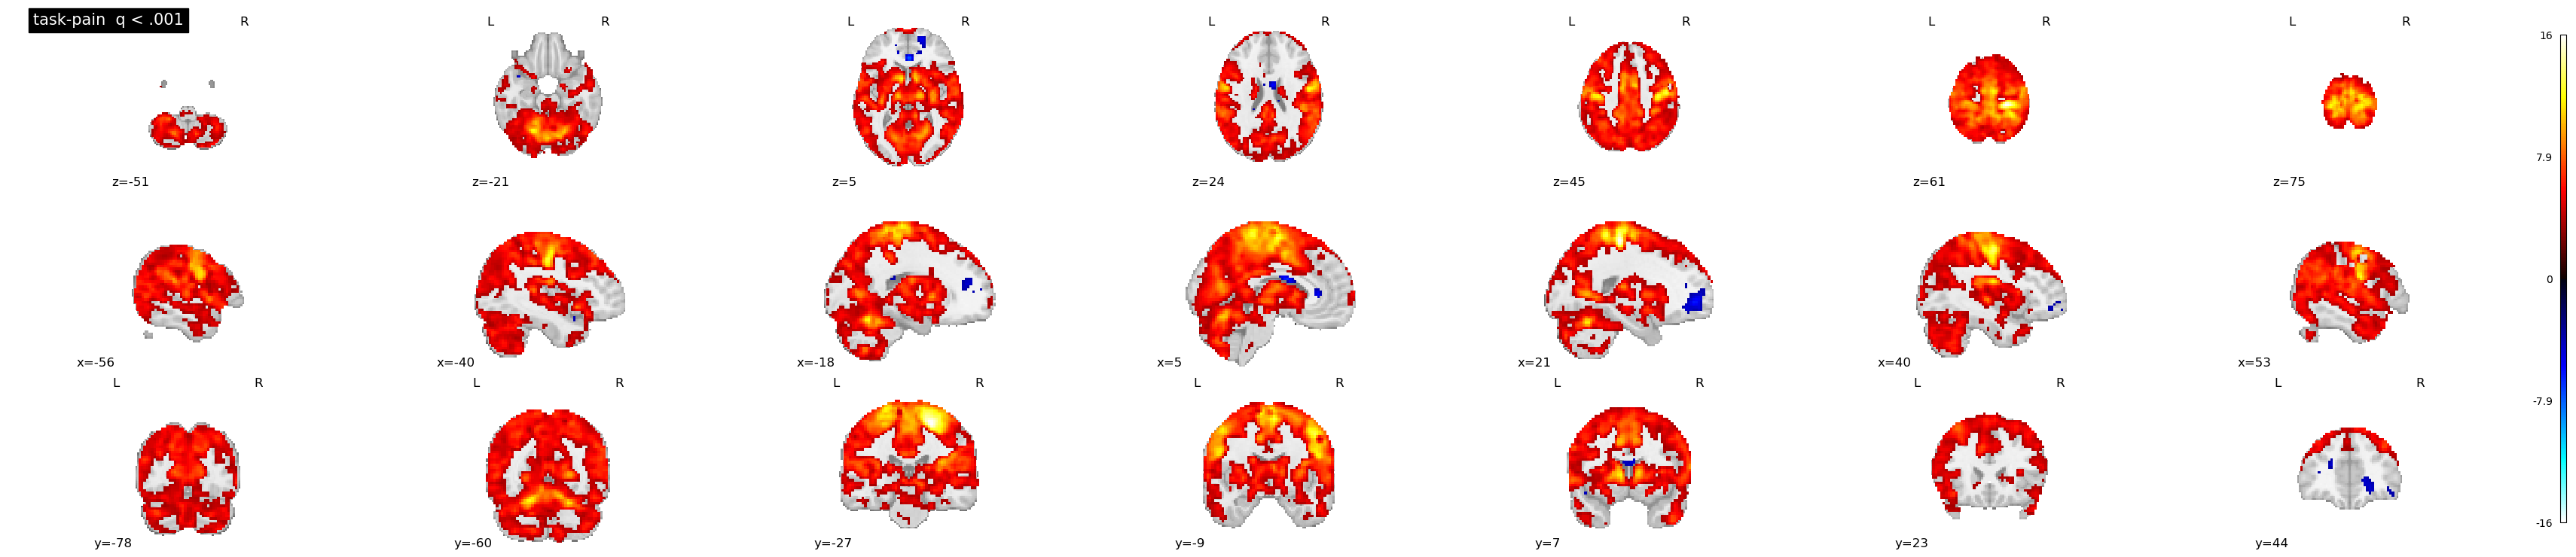

In [53]:
# vicarious
taskname = 'pain'
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hc = []
Lc = []
for index in range(suballHv.shape[0]):

    Hc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighc = np.vstack(Hc)
fmri_masked_stimlowc = np.vstack(Lc)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighc, fmri_masked_stimlowc, 
                                         axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapc = np.zeros(fmri_masked_stimhighc.shape[1])
result_mapc[qvalues < .05] = tvalues[qvalues < .05]
con_tmapc = nifti_masker.inverse_transform(result_mapc)

result_map_001c = np.zeros(fmri_masked_stimhighc.shape[1])
result_map_001c[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001c = nifti_masker.inverse_transform(result_map_001c)

plotting.plot_stat_map(con_tmapc,  display_mode = 'mosaic', title = f'task-{taskname} q < .05')
plotting.plot_stat_map(con_tmap_001c,  display_mode = 'mosaic', title = f'task-{taskname}  q < .001')

# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_p-unthres.nii.gz')
con_tmapc.to_filename(f'singletrial-tmap_task-{taskname}_q-05.nii.gz')
con_tmap_001c.to_filename(f'singletrial-tmap_task-{taskname}_q-001.nii.gz')

In [14]:
print(f"min: {np.min(con_tmap.get_fdata())}")
print(f"max: {np.max(con_tmap.get_fdata())}")
print(f"mean: {np.mean(con_tmap.get_fdata())}")

min: -7.99166474799705
max: 15.719677434507075
mean: 0.7907218503833677


In [63]:
fslr_left_medial.darrays[0].data * stimP_lh

array([5.97315311, 8.17885876, 8.41666222, ..., 3.1575942 , 3.4007628 ,
       3.34308839])

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_98593/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


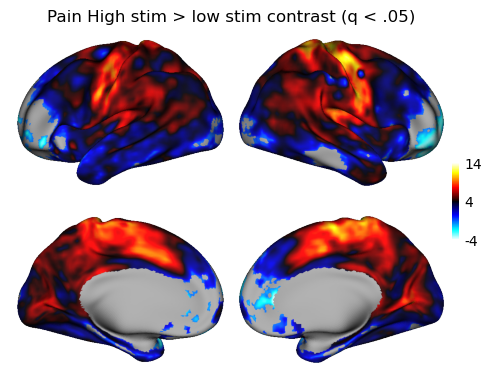

In [66]:
taskname = 'pain'
stimHgtL_P = neuromaps.transforms.mni152_to_fslr('singletrial-tmap_task-pain_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
fslr_left_medial = nib.load(surfaces['medial'].L)
fslr_right_medial = nib.load(surfaces['medial'].R)
masked_stimP_lh = fslr_left_medial.darrays[0].data * stimP_lh
masked_stimP_rh = fslr_right_medial.darrays[0].data * stimP_rh
plot_surf_box(surfaces, 
          surf_lh=masked_stimP_lh, 
          surf_rh= masked_stimP_rh, 
          title=f'Pain High stim > low stim contrast (q < .05)')

# task-vicarious

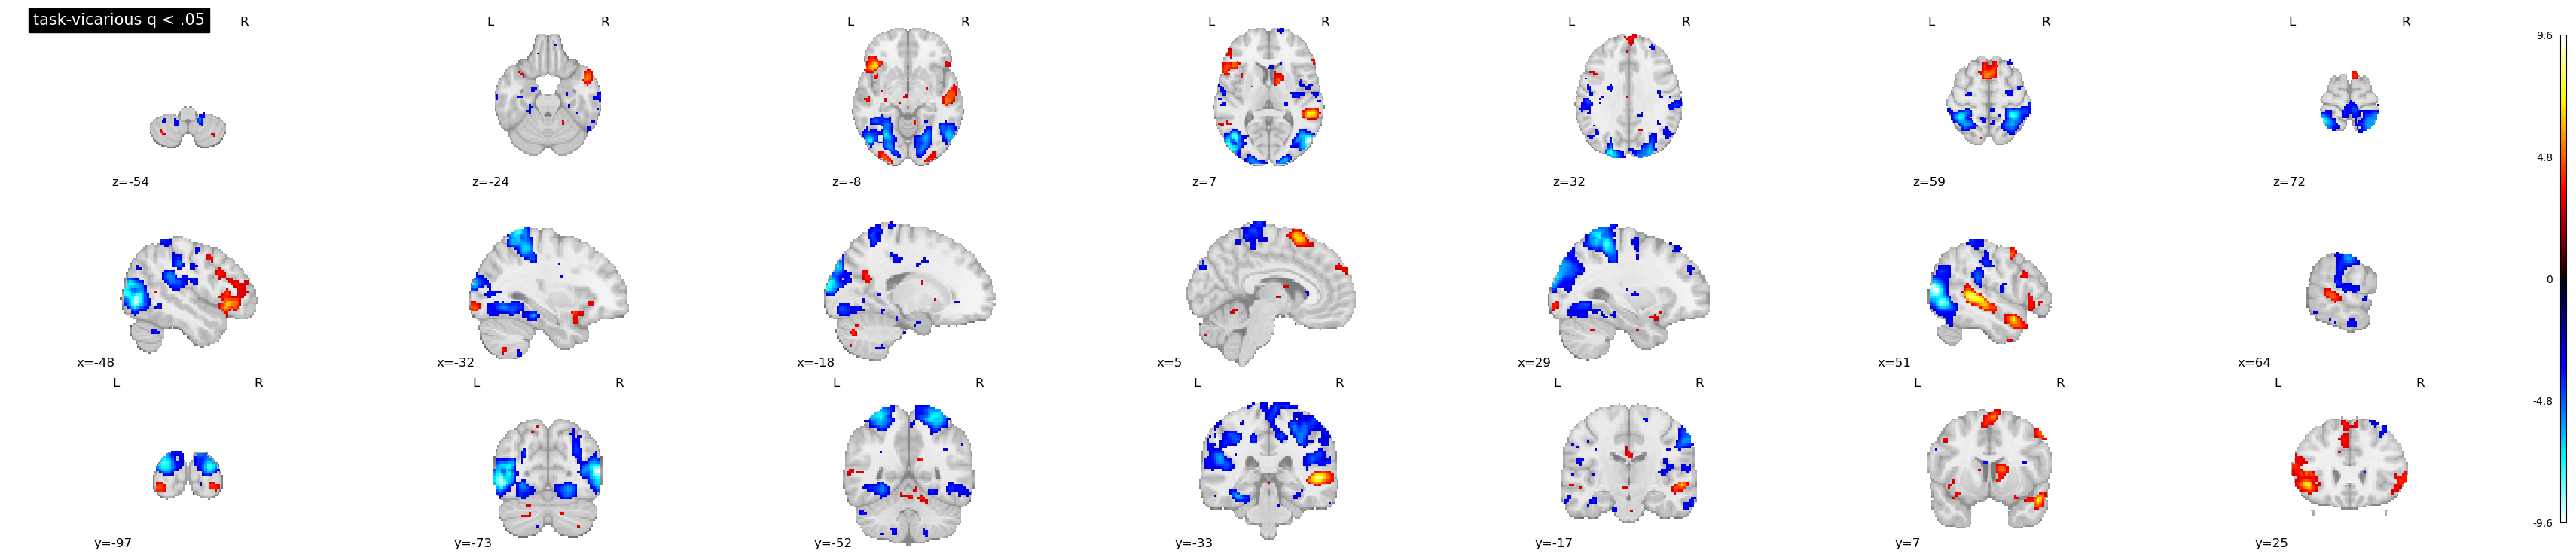

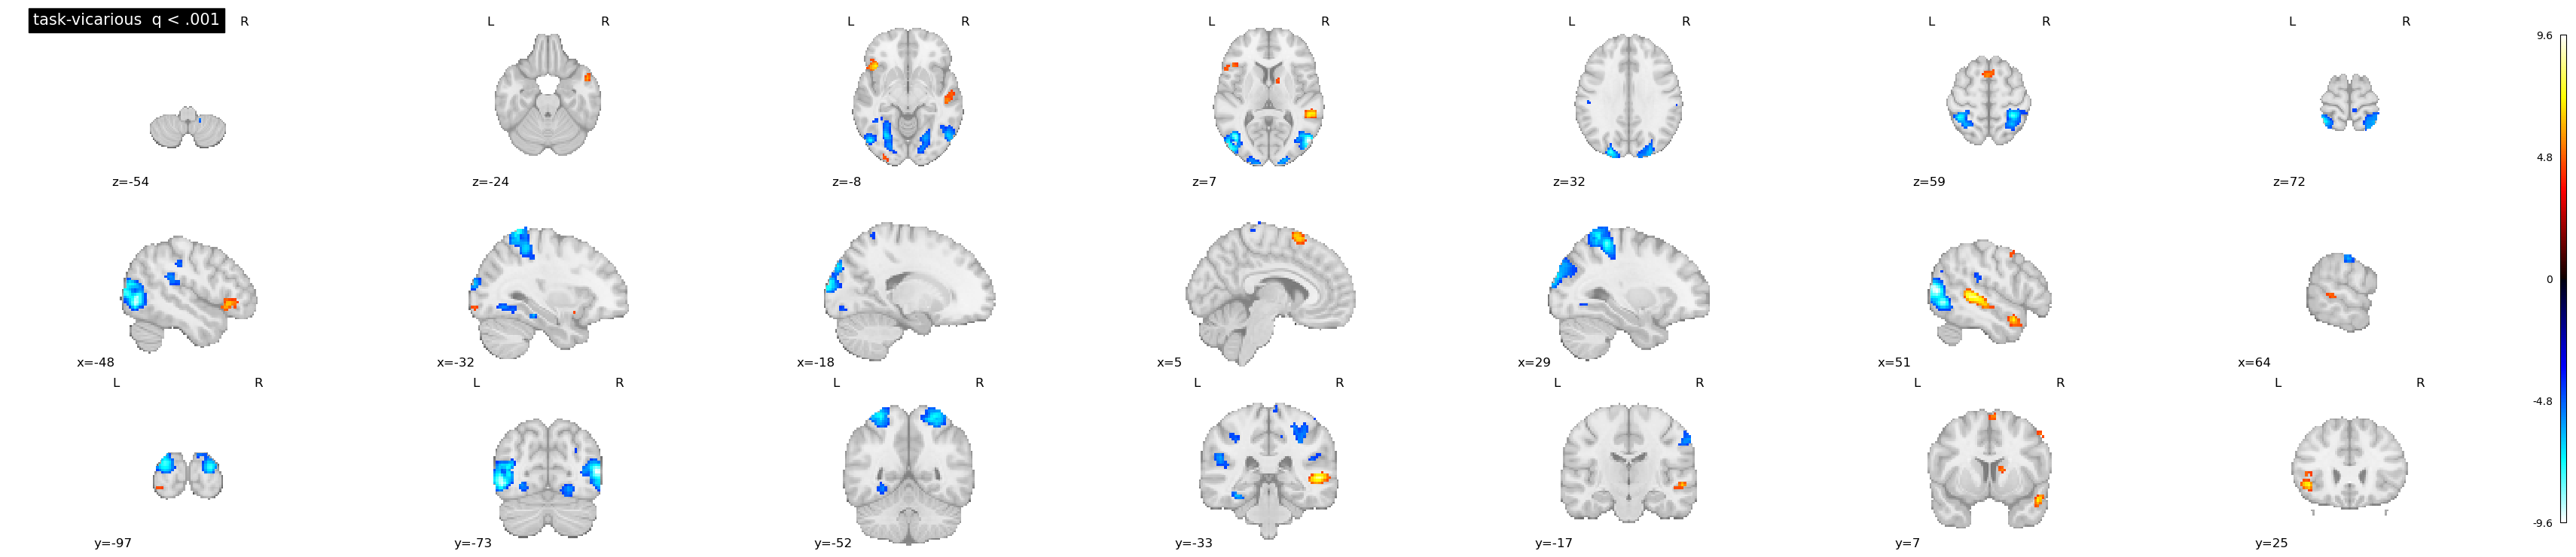

In [38]:
# vicarious
taskname = 'vicarious'
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hc = []
Lc = []
for index in range(suballHv.shape[0]):

    Hc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighc = np.vstack(Hc)
fmri_masked_stimlowc = np.vstack(Lc)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighc, fmri_masked_stimlowc, 
                                         axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapc = np.zeros(fmri_masked_stimhighc.shape[1])
result_mapc[qvalues < .05] = tvalues[qvalues < .05]
con_tmapc = nifti_masker.inverse_transform(result_mapc)

result_map_001c = np.zeros(fmri_masked_stimhighc.shape[1])
result_map_001c[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001c = nifti_masker.inverse_transform(result_map_001c)

plotting.plot_stat_map(con_tmapc,  display_mode = 'mosaic', title = f'task-{taskname} q < .05')
plotting.plot_stat_map(con_tmap_001c,  display_mode = 'mosaic', title = f'task-{taskname}  q < .001')

# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_p-unthres.nii.gz')
con_tmapc.to_filename(f'singletrial-tmap_task-{taskname}_q-05.nii.gz')
con_tmap_001c.to_filename(f'singletrial-tmap_task-{taskname}_q-001.nii.gz')

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_98593/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


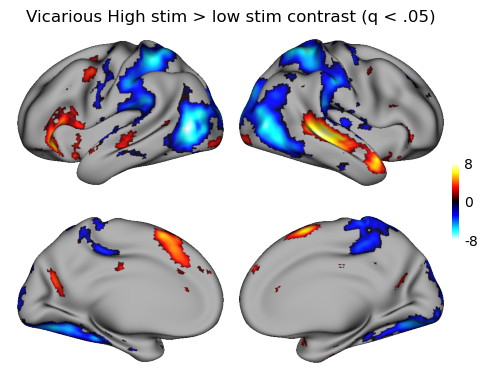

In [51]:
taskname = 'vicarious'
stimHgtL_P = neuromaps.transforms.mni152_to_fslr(f'singletrial-tmap_task-{taskname}_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf_box(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'{taskname.title()} High stim > low stim contrast (q < .05)')

# task-cognitive

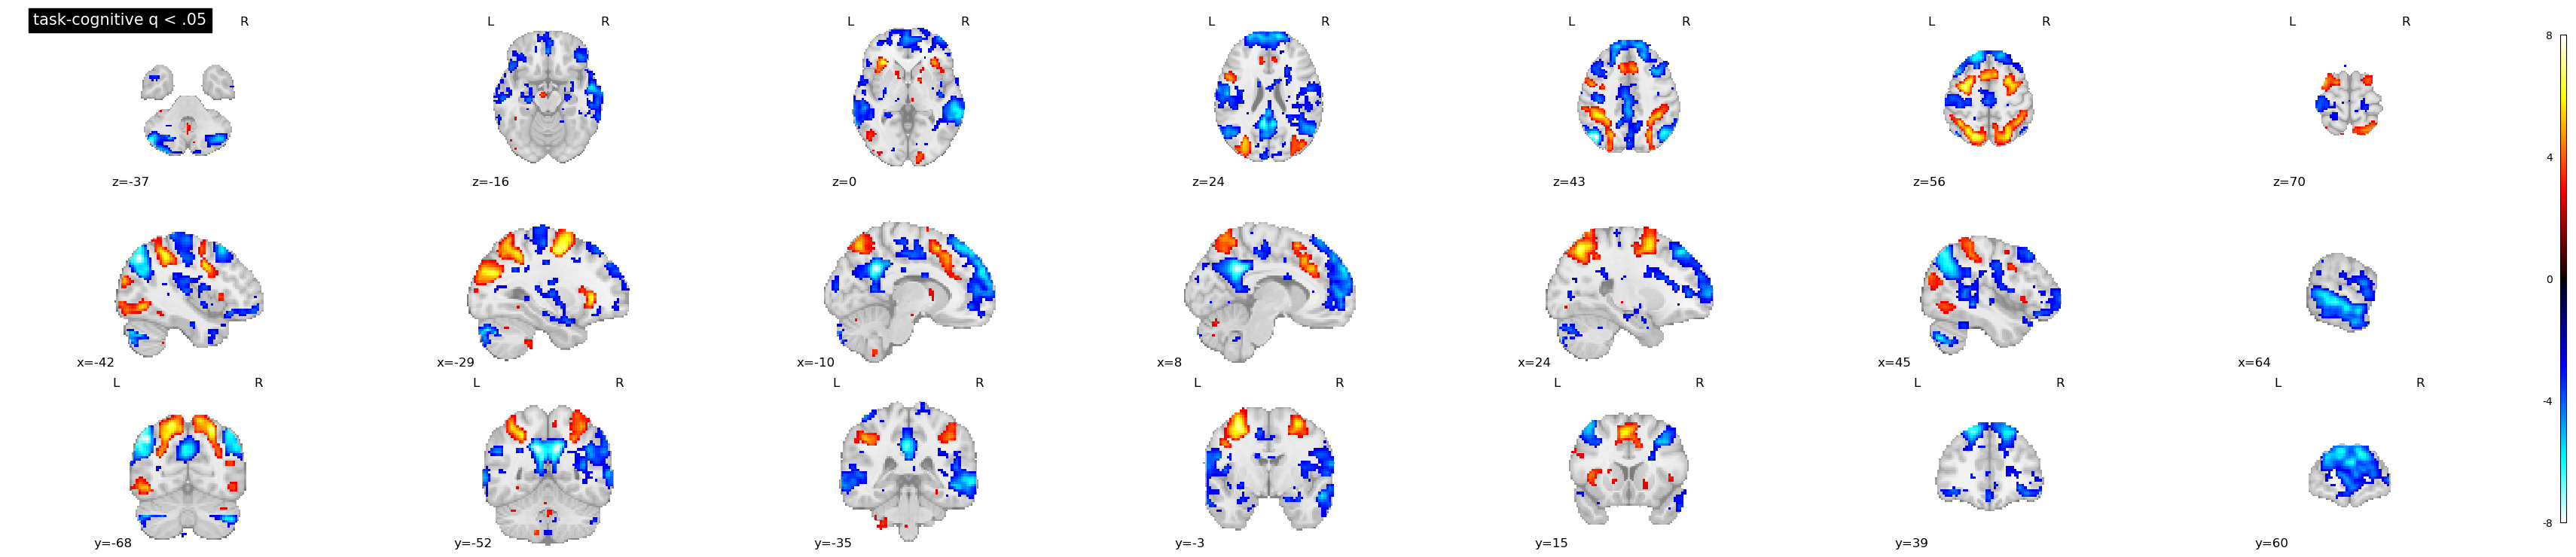

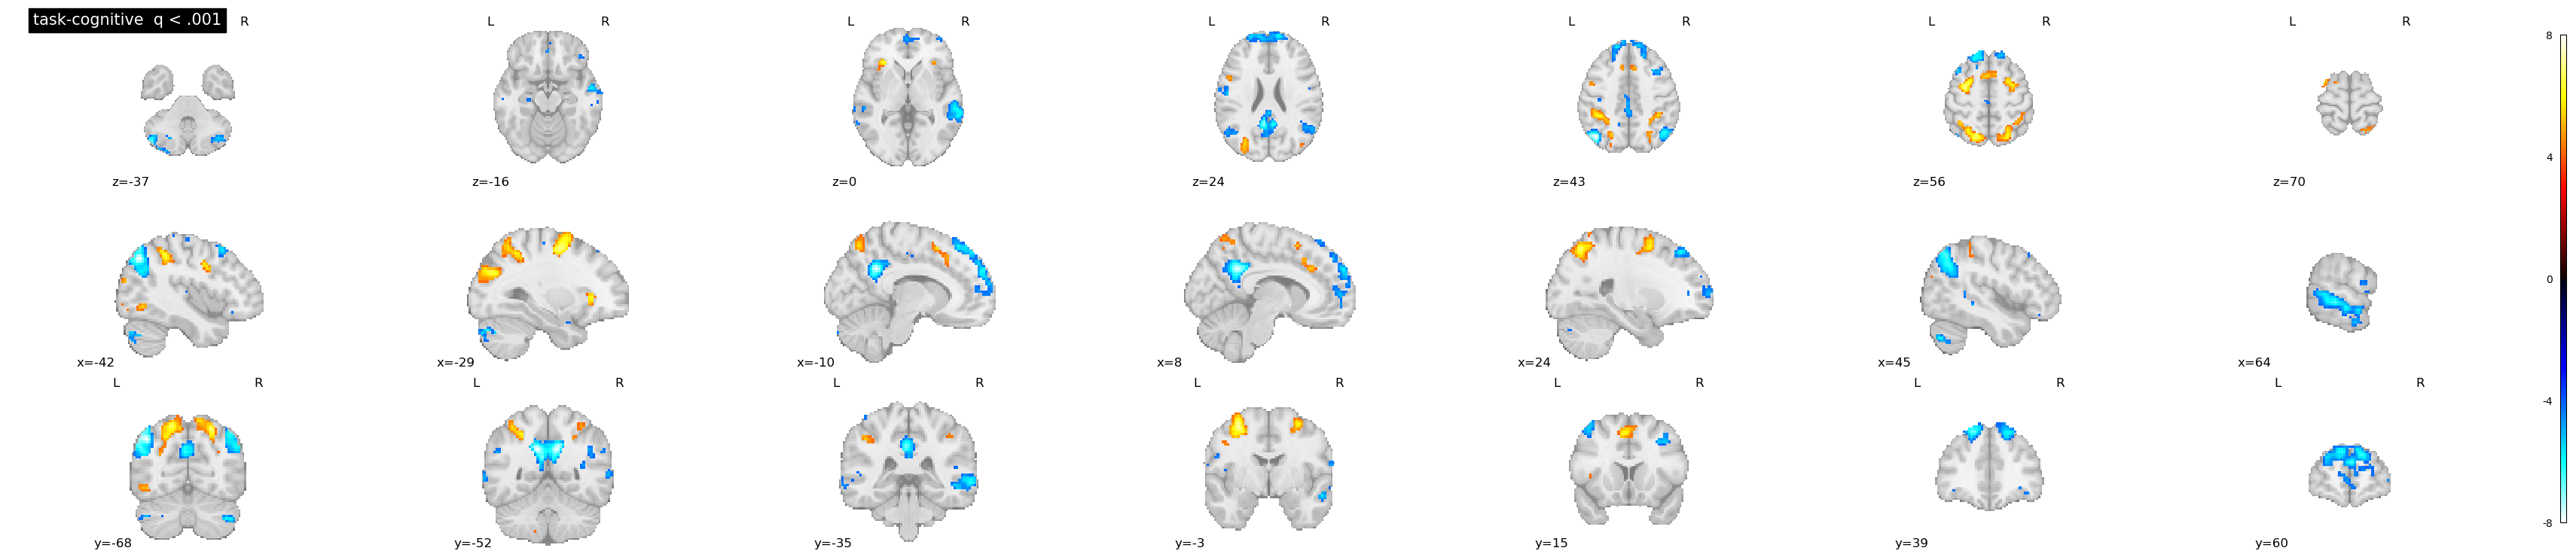

In [41]:
#
# vicarious
taskname = 'cognitive'
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hc = []
Lc = []
for index in range(suballHv.shape[0]):

    Hc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighc = np.vstack(Hc)
fmri_masked_stimlowc = np.vstack(Lc)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighc, fmri_masked_stimlowc, 
                                         axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapc = np.zeros(fmri_masked_stimhighc.shape[1])
result_mapc[qvalues < .05] = tvalues[qvalues < .05]
con_tmapc = nifti_masker.inverse_transform(result_mapc)

result_map_001c = np.zeros(fmri_masked_stimhighc.shape[1])
result_map_001c[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001c = nifti_masker.inverse_transform(result_map_001c)

plotting.plot_stat_map(con_tmapc,  display_mode = 'mosaic', title = f'task-{taskname} q < .05')
tmap_001 = plotting.plot_stat_map(con_tmap_001c,  display_mode = 'mosaic', title = f'task-{taskname}  q < .001')
# tmap_001.title(title = f'task-{taskname}  q < .001', size=30)

# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_p-unthres.nii.gz')
con_tmapc.to_filename(f'singletrial-tmap_task-{taskname}_q-05.nii.gz')
con_tmap_001c.to_filename(f'singletrial-tmap_task-{taskname}_q-001.nii.gz')

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_98593/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


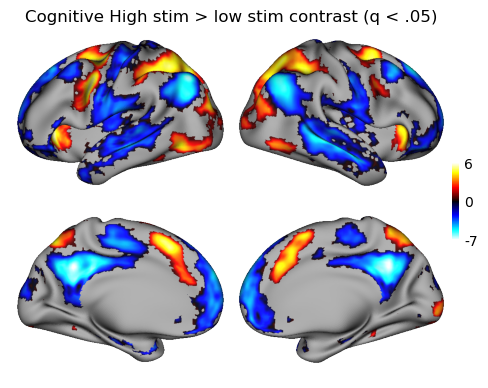

In [50]:

stimHgtL_P = neuromaps.transforms.mni152_to_fslr(f'singletrial-tmap_task-{taskname}_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf_box(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'{taskname.title()} High stim > low stim contrast (q < .05)')